In [13]:
from BFCalc.BFInterp import DM_spectrum_setup
from BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc
from utils import log10eaxis, logjacob, makedist, makelogjacob, bkgdist, edisp, offsetaxis, fake_signal_position_dist, inverse_transform_sampling, psf, norme_vals_mesh, normoffset_vals_mesh, setup_full_fake_signal_dist
from utils import psffull
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from scipy import special,stats
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm
import os, sys
sys.path.append("BFCalc")

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_34628/86125427.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('coolwarm')
/Users/lpin0002/Desktop/DMPipe/utils.py:67: RuntimeWarning: divide by zero encountered in log
  psffunc = lambda offsetrecon: np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


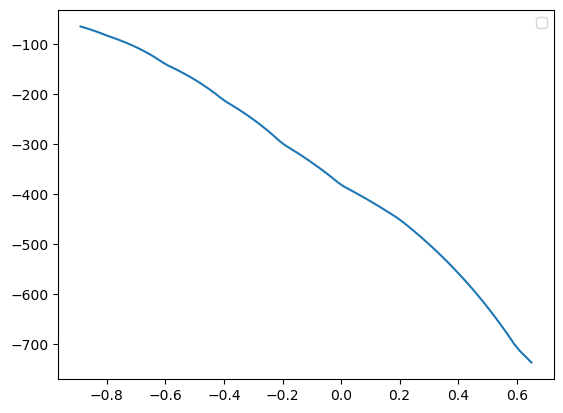

/Users/lpin0002/Desktop/DMPipe/utils.py:53: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,


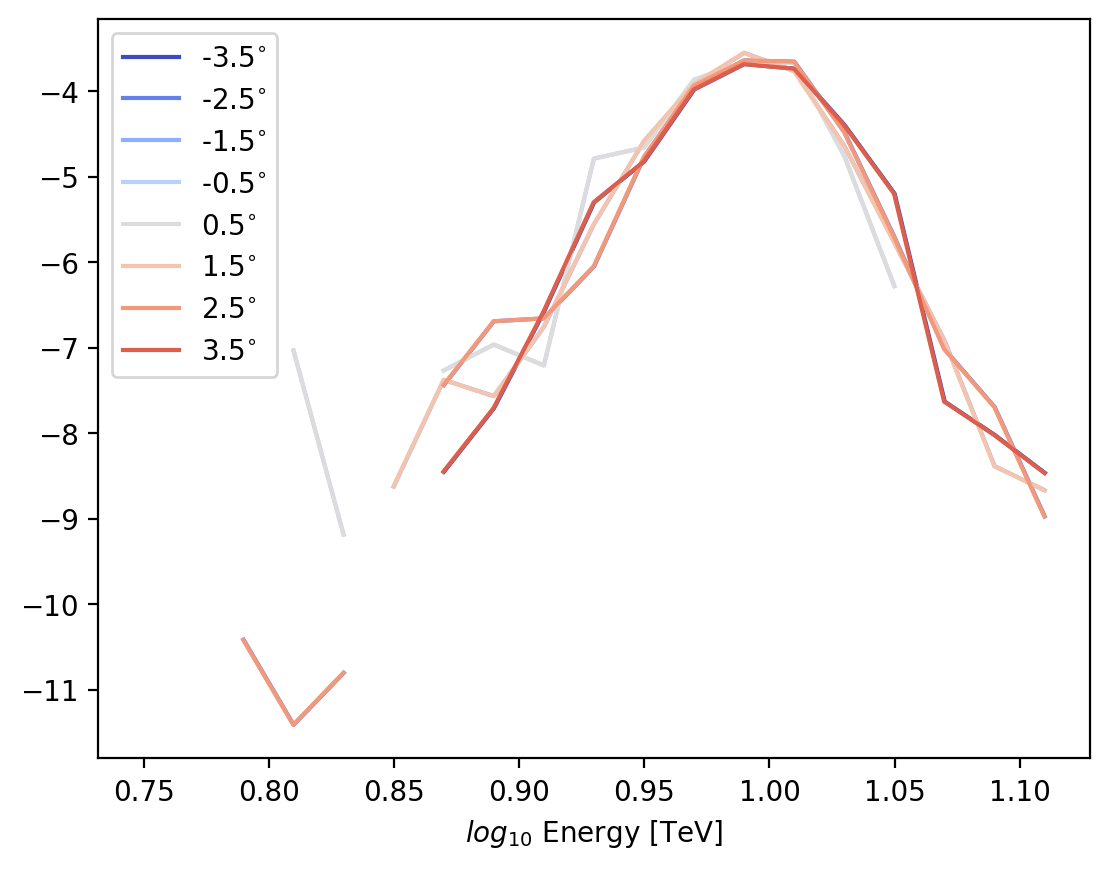

In [14]:
offsetvals = np.linspace(-3.5,3.5,8)
logevals = np.linspace(-1,2,31)
offsetvalsmesh, logevalsmesh = np.meshgrid(offsetaxis, log10eaxis)


colormap = cm.get_cmap('coolwarm')


plt.figure()
plt.plot(log10eaxis, psf(2.5, 1.5, log10eaxis))
plt.legend()
plt.show()


plt.figure(dpi=200)
for i, offsetval in enumerate(offsetaxis):
    plt.plot(log10eaxis-5e-3*i/log10eaxis.shape[0], edisp(log10eaxis, 1.0, offsetval),c = colormap(i/offsetaxis.shape[0]), label=f"{offsetval}"+r"$^{\circ}$")
    # print(max(edisp(log10eaxis, -1.0, offsetval)))
plt.xlabel(r'$log_{10}$ Energy [TeV]')
# plt.ylim([-7,2])
plt.legend()
plt.show()

In [18]:
edispmatrix = np.empty(shape=(log10eaxis.shape[0], log10eaxis.shape[0]))

for ii, log10eval in notebook_tqdm(enumerate(log10eaxis), total=log10eaxis.shape[0]):
    edispmatrix[ii,:] = edisp(log10eaxis, log10eval, 3.5)
    
    
psfmatrix = np.empty(shape=(offsetaxis.shape[0], offsetaxis.shape[0]))

for ii, offsetval in notebook_tqdm(enumerate(offsetaxis), total=offsetaxis.shape[0]):
    psfmatrix[ii,:] = psf(offsetaxis, offsetval, -0.9)



  0%|          | 0/145 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/utils.py:53: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
  0%|          | 0/8 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/utils.py:67: RuntimeWarning: divide by zero encountered in log
  psffunc = lambda offsetrecon: np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
100%|██████████| 8/8 [00:00<00:00, 16.68it/s]


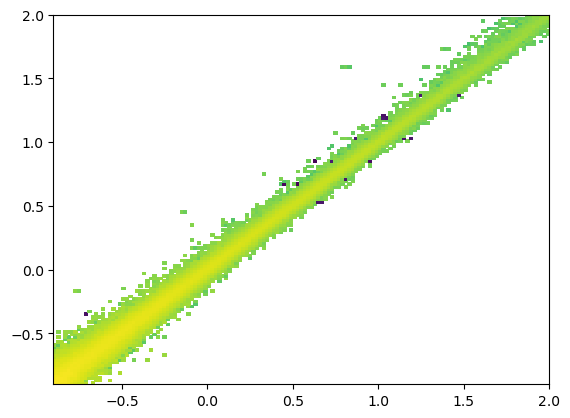

In [19]:
plt.figure()
plt.pcolor(log10eaxis, log10eaxis, edispmatrix)
plt.show()

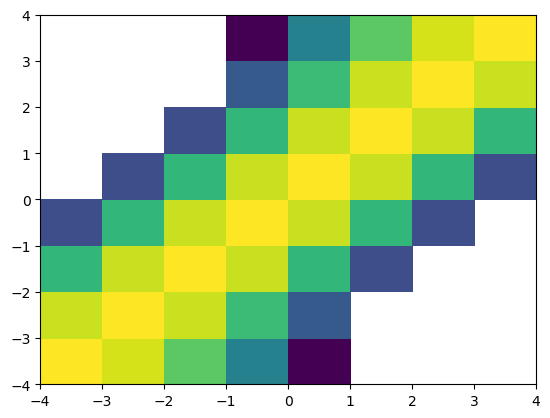

In [20]:
plt.figure()
plt.pcolor(offsetaxis, offsetaxis, psfmatrix)
plt.show()

In [25]:
log10emesh, offsetmesh = np.meshgrid(log10eaxis, offsetaxis)
Nsamples=int(1e2)
truelogmassval = 0.5

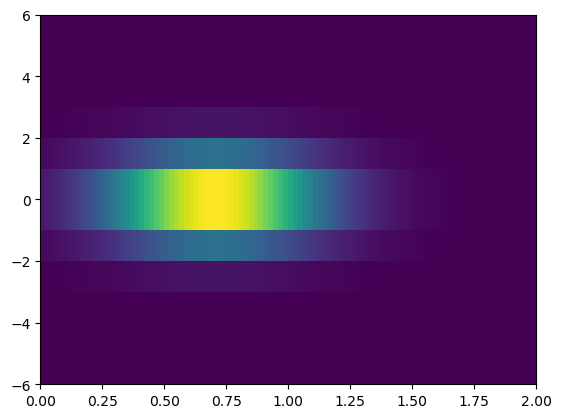

In [26]:
plt.figure()
plt.pcolormesh(log10eaxis, offsetaxis, np.exp(setup_full_fake_signal_dist(truelogmassval, normeaxis=10**log10eaxis)(log10emesh, offsetmesh)+logjacob))

In [27]:
sigbinnedprior = setup_full_fake_signal_dist(truelogmassval, normeaxis=10**log10eaxis)(log10emesh, offsetmesh)+logjacob
flattened_sigbinnedprior = sigbinnedprior.flatten()

sigresultindices = np.unravel_index(inverse_transform_sampling(flattened_sigbinnedprior, Nsamples=Nsamples),sigbinnedprior.shape)
siglogevals = log10eaxis[sigresultindices[1]]
sigoffsetvals = offsetaxis[sigresultindices[0]]

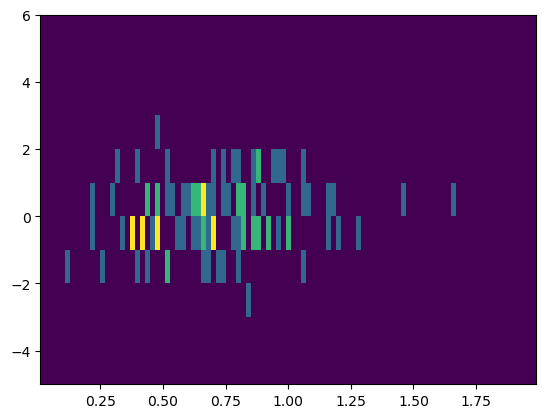

In [28]:
plt.figure()
plt.hist2d(siglogevals, sigoffsetvals, bins=[log10eaxis, offsetaxis+0.5*(offsetaxis[1]-offsetaxis[0])])
# for val in offsetaxis+0.5*(offsetaxis[1]-offsetaxis[0]):
#     plt.axhline(val, alpha=0.1, c='tab:orange')
plt.show()

In [29]:
signal_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, offsetval)+logjacob, Nsamples=1) for logeval, offsetval in notebook_tqdm(zip(siglogevals, sigoffsetvals), total=Nsamples)])]

  0%|          | 0/100 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
100%|██████████| 100/100 [00:05<00:00, 18.90it/s]


In [30]:
signal_offset_measured = offsetaxis[np.squeeze([inverse_transform_sampling(psf(offsetaxis, offsetval, logeval), Nsamples=1) for logeval, offsetval in notebook_tqdm(zip(siglogevals, sigoffsetvals), total=Nsamples)])]


100%|██████████| 100/100 [00:00<00:00, 11223.12it/s]


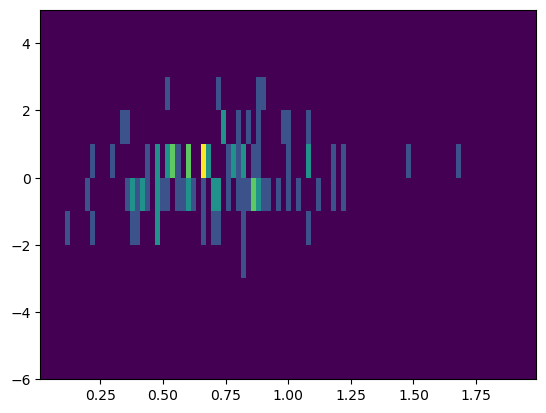

100.0

In [31]:
plt.figure()
histvals = plt.hist2d(signal_log10e_measured, signal_offset_measured, bins=[log10eaxis, offsetaxis-0.5*(offsetaxis[1]-offsetaxis[0])])
plt.show()

np.sum(histvals[0])

part3 [array([       -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf, -7.88407202, -8.30017203,
       -6.94371533, -5.19253092, -4.49777291, -4.25220866, -4.10736875,
       -4.20985759, -4.60246645, -5.09882471, -6.00133746, -7.01030489,
       -7.77549155, -8.1980417 ,        -inf,        -inf, -8.48875858,
              -inf,        -inf,        -inf,        -inf

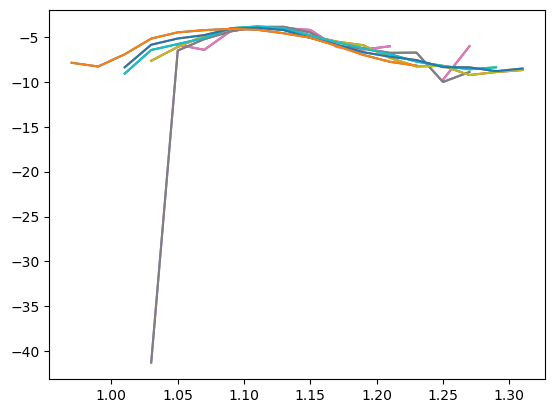

In [32]:
log10emesh, offsetmesh = np.meshgrid(log10eaxis, offsetaxis)

part1 = setup_full_fake_signal_dist(truelogmassval, normeaxis=10**log10eaxis)(log10emesh, offsetmesh)
part2=logjacob
part3=edisp(signal_log10e_measured[0], log10emesh, offsetmesh)
part4=psf(signal_offset_measured[0], offsetmesh, log10emesh)


# print('part1', part1)
# print('part2', part2)
print('part3', list(part3))

plt.figure()
plt.plot(log10eaxis, part3.T)
# print('part4', part4)

In [33]:
special.logsumexp(part1+part2+part3+part4)

-8.153581559161601

In [34]:

def evaluateintegral(priorvals, logemeasured, offsetmeasured, log10emesh, offsetmesh):
    
    energyloglikelihoodvals=edisp(logemeasured, log10emesh, offsetmesh)
    pointspreadlikelihoodvals=psf(offsetmeasured, offsetmesh, log10emesh)
    integrand = priorvals+logjacob+energyloglikelihoodvals+pointspreadlikelihoodvals
    return special.logsumexp(integrand)


def evaluateformass(logmass, logemasuredvals, offsetmeasuredvals):
    log10emesh, offsetmesh = np.meshgrid(log10eaxis, offsetaxis)

    priorvals = setup_full_fake_signal_dist(logmass, normeaxis=10**log10eaxis)(log10emesh, offsetmesh)
        
    product = np.sum([evaluateintegral(priorvals, logemeasured, offsetmeasured, log10emesh, offsetmesh) for logemeasured, offsetmeasured in zip(logemasuredvals, offsetmeasuredvals)])
    
    return product

In [35]:
massvals = np.linspace(truelogmassval-1/np.sqrt(Nsamples/10),truelogmassval+1/np.sqrt(Nsamples/10),61)
logposterior = [evaluateformass(logmass, signal_log10e_measured, signal_offset_measured) for logmass in notebook_tqdm(massvals)]

 16%|█▋        | 10/61 [01:33<07:59,  9.40s/it]

KeyboardInterrupt: 

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_10540/728709235.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_10540/728709235.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb1 = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap), ticks=np.arange(1,5))


0.9999999999999991


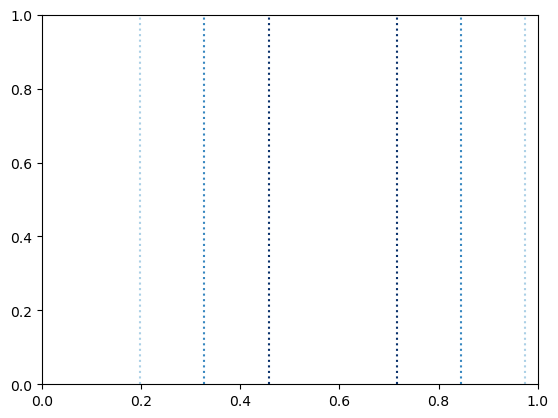

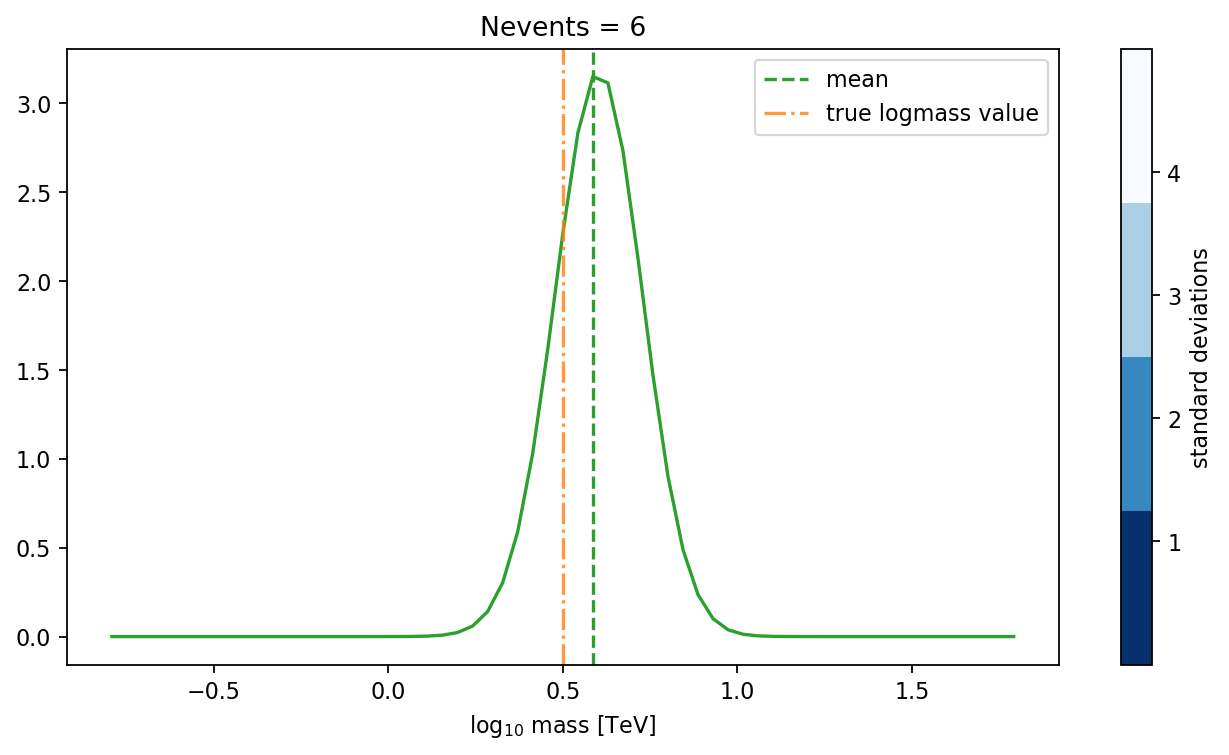

In [ ]:
from scipy.stats import norm
from matplotlib import cm
import time

colormap = cm.get_cmap('Blues_r', 4)




deltalogmass = (massvals[1]-massvals[0])
normedposterior = np.exp(logposterior-special.logsumexp(logposterior+np.log(deltalogmass)))
cdfposterior = np.cumsum(normedposterior*deltalogmass)
print(cdfposterior[-1])
mean = massvals[np.abs(0.5-cdfposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
percentiles = []
for zscore in zscores:
    percentiles.append(massvals[np.abs(norm.cdf(zscore)-cdfposterior).argmin()])



plt.figure(dpi=160, figsize=(10,5))
plt.title(f'Nevents = {Nsamples}')
plt.plot(massvals, normedposterior, c='tab:green')
plt.axvline(mean, c='tab:green', ls='--', alpha=1, label='mean')

for o, percentile in enumerate(percentiles):
    color = colormap(np.abs(zscores[o])/4-0.01)

    plt.axvline(percentile, c=color, ls=':')

plt.axvline(truelogmassval, c='tab:orange', ls='-.', label='true logmass value', alpha=0.8)
plt.xlabel(r'log$_{10}$ mass [TeV]')
norm = mpl.colors.Normalize(vmin=0, vmax=5)

cb1 = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap), ticks=np.arange(1,5))
cb1.set_label(r'standard deviations')
plt.legend()
plt.savefig(time.strftime(f'Figures/TestFigures/logmassposterior_%m%d_%H%M_logmass={truelogmassval}.png'))
plt.show()

In [18]:
offsetvals = np.linspace(-5.5,5.5,12)
logevals = np.linspace(-1,2,31)

offsetvalsmesh, logevalsmesh = np.meshgrid(offsetaxis, log10eaxis)




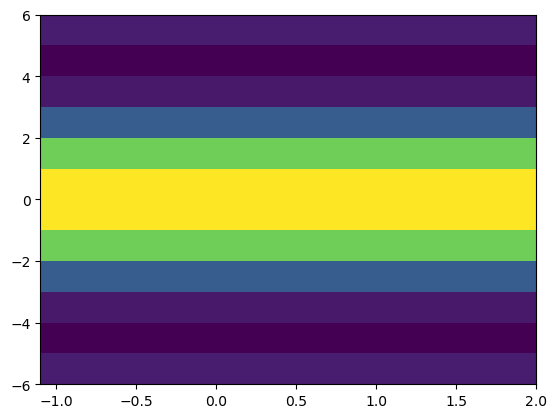

In [19]:
plt.figure()
plt.pcolormesh(log10eaxis, offsetaxis, np.exp(psf(0.0, offsetvalsmesh, logevalsmesh)).T)

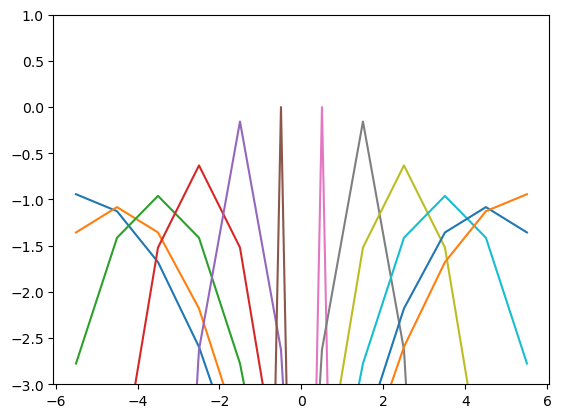

KeyboardInterrupt: 

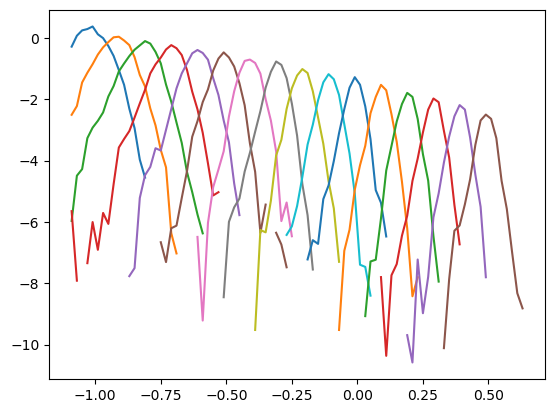

In [20]:
plt.figure()
for offsetval in offsetvals:
    plt.plot(offsetaxis, psf(offsetaxis, offsetval, 0.0))

plt.ylim([-3,1])
plt.show()


plt.figure()
for log10eval in logevals:
    plt.plot(log10eaxis, edisp(log10eaxis, log10eval, 0.0))
plt.ylim([-5,2])
plt.show()

In [ ]:
testmatrix = np.zeros(shape=(3,2,5))
testarray  = np.arange(1,4)
testarray

array([1, 2, 3])

In [ ]:
normalisation = np.sum((testmatrix.T+testarray).T, axis=0)
testmatrix-normalisation

array([[[-6., -6., -6., -6., -6.],
        [-6., -6., -6., -6., -6.]],

       [[-6., -6., -6., -6., -6.],
        [-6., -6., -6., -6., -6.]],

       [[-6., -6., -6., -6., -6.],
        [-6., -6., -6., -6., -6.]]])

Message Ulrik